### EMTOOLS -- Validation
**Description:** This notebook computes pixel-wise and instance-wise validation measures for the EM pipeline. Including Dice score, IoU, False Positive/Negative%.

**Author:** Philip Ruthig, Paul Flechsig Institute, Center of Neuropathology and Brain Research Leipzig

**Contact:** philip.ruthig@medizin.uni-leipzig.de // philip.ruthig@gmail.com

**Publication:**
Please contact me if you want to use this code for any publication.

In [1]:
import numpy as np
import tifffile as tf
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import cv2
import scipy
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import disk
import colorcet as cc
%matplotlib inline

c:\Users\Hoellenmaschine2\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def resolve_undersegmentation(outer_labels,inner_labels):
    '''
    resolves undersegmented cells with 'kissing' cells. This function assumes that inner_labels never touch, but outer_labels do.
    Each corresponding outer area must touch each corresponding inner area.

    outer_labels = outer labels with undersegmented kissing cells that need to be seperated
    inner_labels = inner labels without undersegmented kissing cells

    returns: Two arrays of the same shape, with uniform labels across both images. 
    '''
    import numpy as np
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    outer_labels = outer_labels.astype('bool')
    inner_labels = inner_labels.astype('bool')
    # do distance transformation of combined binary image of outer+inner
    seg_dist = ndi.distance_transform_edt(outer_labels+inner_labels)
    # Generate the markers as local maxima of the distance to the background
    coords = peak_local_max(seg_dist, footprint=np.ones((3, 3)), labels=ndi.label(inner_labels)[0], num_peaks_per_label=1)
    # initializie empty mask 
    mask = np.zeros(seg_dist.shape, dtype=bool)
    # insert maximum points into the empty array
    mask[tuple(coords.T)] = True
    # label each maximum
    markers, n = ndi.label(mask)
    # perform watershed on outer_labels and inner_labels combined
    outer_cells = watershed(-seg_dist, markers, mask=(outer_labels+inner_labels))
    inner_cells = np.copy(outer_cells)
    # sort the cells (which are now labeled with the same label inner and outer) back into inner and outer labels
    inner_cells[inner_labels==0] = 0
    outer_cells[inner_labels==True] = 0
    return outer_cells,inner_cells

def keep_largest_structure(boolean_array):
    '''
    This function checks for structures of the same label and keeps only the biggest one.
    This is needed for cells that are double labeled so we can keep the largest one (which, we assume, is the real one).
    This function should only called for a mask of a single cell each time, as it assumes there is only one label in the input array.
    '''
    labeled_array, num_features = ndi.label(boolean_array) # Label each connected component in the boolean array
    component_sizes = np.bincount(labeled_array.ravel()) # Calculate the size of each labeled component
    largest_component_index = np.argmax(component_sizes[1:]) + 1 # Find the index of the largest component
    largest_component_mask = labeled_array == largest_component_index # Create a boolean mask to keep only the largest component
    # Apply the mask to the boolean array
    boolean_array[largest_component_mask] = True
    boolean_array[~largest_component_mask] = False

    return boolean_array

def calculate_iou(predicted_mask, ground_truth_mask):
    # IoU Score is equivalent to Jaccard
    intersection = predicted_mask & ground_truth_mask # element-wise logical AND
    union = predicted_mask | ground_truth_mask #element-wise logical OR

    # calculate the number of pixels in the intersection and union masks
    n_intersection = intersection.sum()
    n_union = union.sum()

    # calculate the IoU score
    iou = n_intersection / n_union

    return iou

def calculate_dice(predicted_mask, ground_truth_mask):
    # Dice coefficient is equivalent to F1 score.
    intersection = np.sum(predicted_mask[ground_truth_mask == True] == True)
    sum_predicted = np.sum(predicted_mask[predicted_mask == True] == True)
    sum_ground_truth = np.sum(ground_truth_mask[ground_truth_mask == True] == True)

    dice = (2.0 * intersection) / (sum_predicted + sum_ground_truth)
    return dice


# define qualitative colormap
glasbey = cc.cm.glasbey_dark_r
glasbey.set_under(color="black")

In [3]:
prediction_path =  r"4_val/prediction_cc.png" #prediction file
validation_path = r"4_val/validation_cc.png" #ground truth file
save_path = r"5_val_results/"

swm = True #True for swm validation, false for CC

threshold_myelin = 50
threshold_fiber_upper = 40 

if swm == True:
    threshold_fiber_lower = 28
else:
    threshold_fiber_lower = 24

threshold_fiber_lower = 26


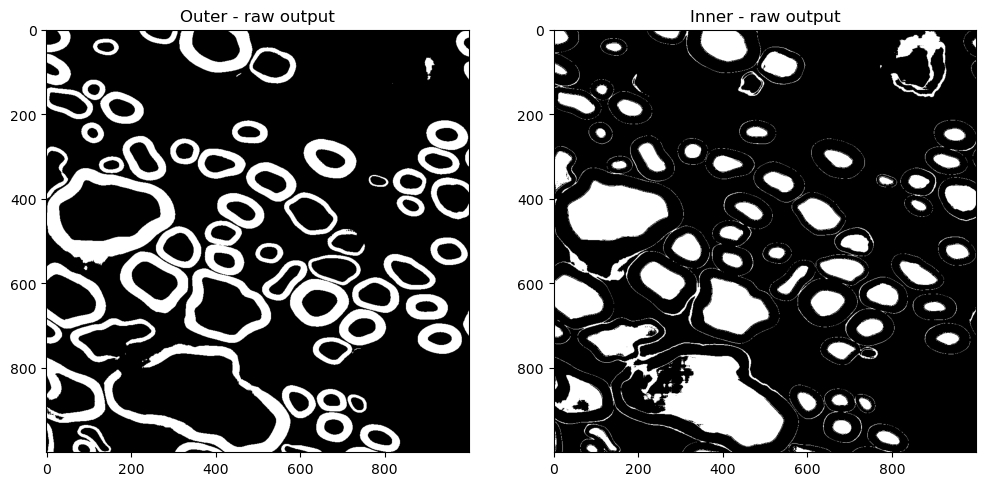

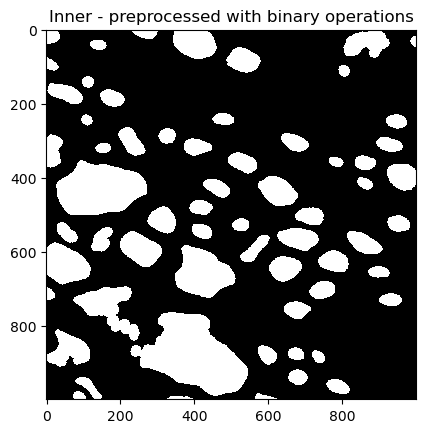

In [4]:
# open data
img = cv2.imread(prediction_path)
img_val = cv2.imread(validation_path)
val_inner = img_val[:,:,2]
val_outer = img_val[:,:,0]

# lose two dimensions, since its a grayscale img 
img = img[:,:,0]

# # plot histogram of pixel intensities in the semantic segmentation
# plt.hist(img.ravel(), bins=256, range=(0, 255),)
# plt.show()

# split different labels
pred_outer = np.zeros_like(img) # myelin
pred_inner = np.zeros_like(img) # fibers

# Treshold the input image at given thresholds (defined in above cell)
pred_outer[img>threshold_myelin] = 1
pred_inner[img<threshold_fiber_upper] = 1
pred_inner[img<threshold_fiber_lower] = 0

# plot raw threshold
fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer[0:1000,0:1000], cmap='gray')
axs[1].imshow(pred_inner[0:1000,0:1000], cmap='gray')
axs[0].set_title('Outer - raw output')
axs[1].set_title('Inner - raw output')
plt.show()

# binary opening to get rid of small speckles
pred_inner = ndi.binary_opening(pred_inner,structure=disk(5))

# fill holes
# pred_inner = ndi.binary_fill_holes(pred_inner)

# binary opening to get rid of small speckles (again)
pred_inner = ndi.binary_opening(pred_inner,structure=disk(5))

# fill inner to outer label to make sure they touch
pred_inner = ndi.binary_dilation(pred_inner,structure=disk(5))
pred_inner[pred_outer==True]=0

# binary opening to get rid of small speckles
pred_inner = ndi.binary_opening(pred_inner,structure=disk(2))

# fill holes
pred_inner = ndi.binary_fill_holes(pred_inner)

# # binary opening to get rid of small speckles
# pred_inner = ndi.binary_opening(pred_inner,structure=disk(6))

# dilate inner
pred_inner = ndi.binary_dilation(pred_inner,structure=disk(3))

plt.title('Inner - preprocessed with binary operations')
plt.imshow(pred_inner[0:1000,0:1000],interpolation='None',cmap='gray')
plt.show()

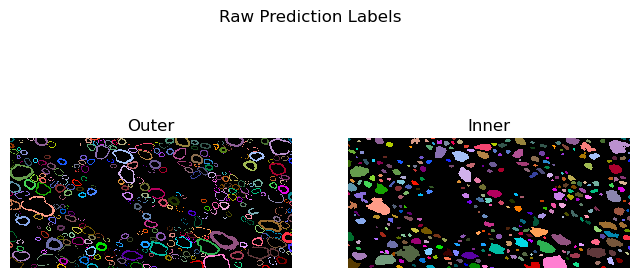

Number of raw predicted cells in the inner channel: 343


In [5]:
pred_outer_labeled, pred_inner_labeled = resolve_undersegmentation(pred_outer.astype('bool'), pred_inner.astype('bool'))

# Plot raw prediction outer and inner side by side
plt.figure(figsize=(8, 4))
plt.suptitle('Raw Prediction Labels', fontsize=12)

# Display raw prediction outer
plt.subplot(1, 2, 1)
plt.title('Outer')
plt.imshow(pred_outer_labeled, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.axis('off')

# Display raw prediction inner
plt.subplot(1, 2, 2)
plt.title('Inner')
plt.imshow(pred_inner_labeled, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.axis('off')
plt.show()
# Print the number of raw predicted cells in the inner channel
n_pred_cells_raw = np.max(pred_inner_labeled)
print("Number of raw predicted cells in the inner channel:", n_pred_cells_raw)


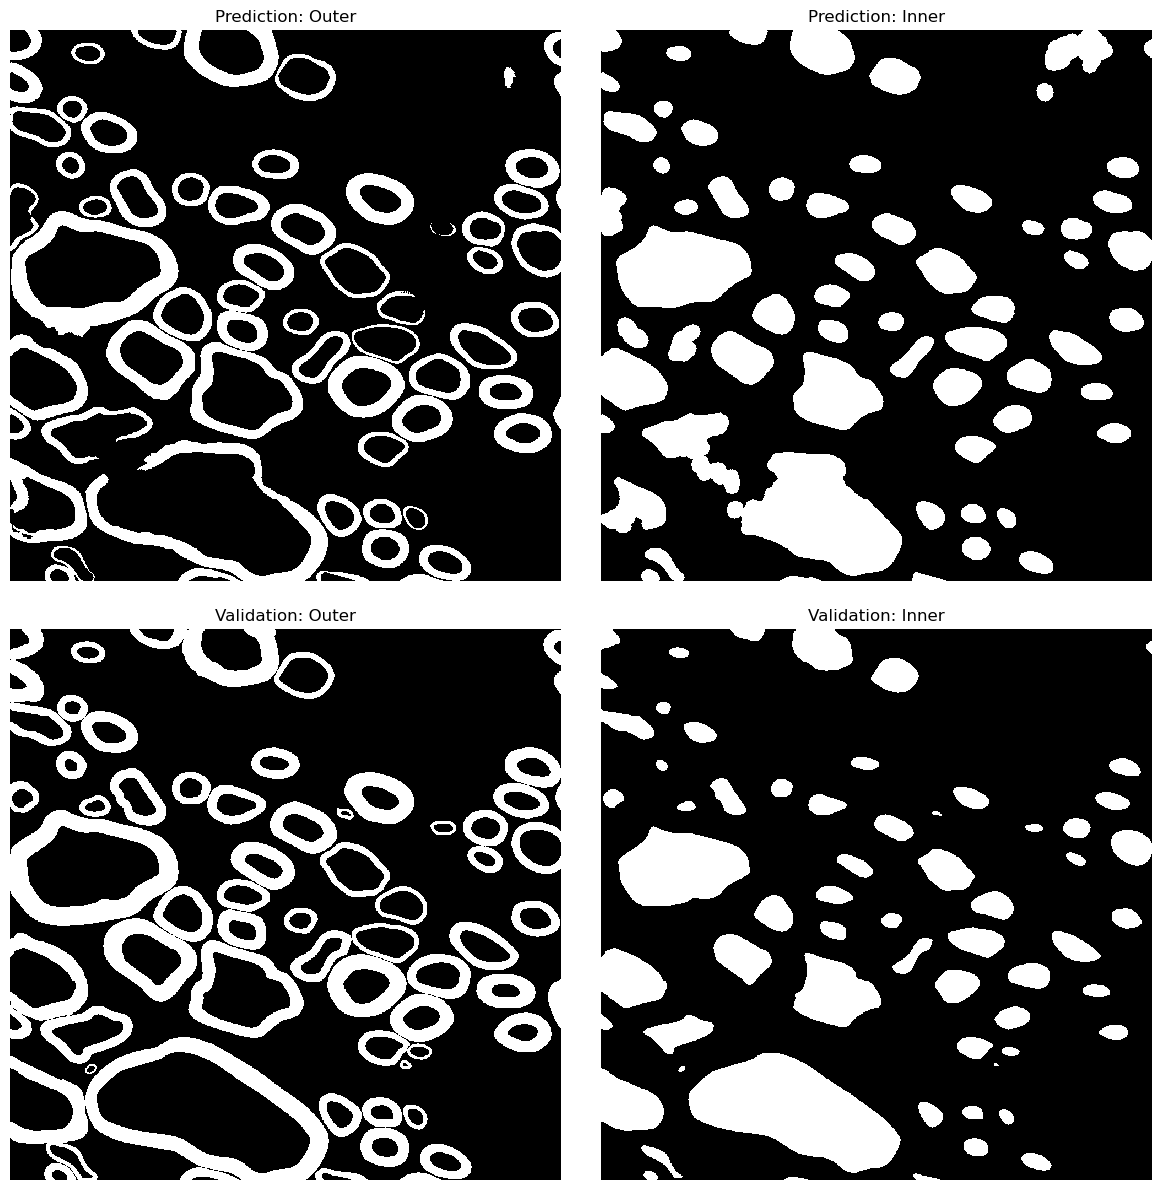

In [6]:
#plot all four channels in 2x2 grid
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
axs[0,0].imshow(pred_outer_labeled[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)
axs[0,1].imshow(pred_inner_labeled[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)
axs[1,0].imshow(val_outer[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)
axs[1,1].imshow(val_inner[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)

# Remove axis for each subplot
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[0,0].set_title('Prediction: Outer')
axs[0,1].set_title('Prediction: Inner')
axs[1,0].set_title('Validation: Outer')
axs[1,1].set_title('Validation: Inner')
plt.tight_layout(h_pad=2)
plt.savefig(save_path + "\predict_val_comparison.png",dpi=500)
plt.show()

In [7]:
# print(len(np.unique(pred_outer_labeled)))
# print(len(np.unique(pred_inner_labeled)))
# print(np.unique(pred_outer_labeled))
# print(np.unique(pred_inner_labeled))

In [8]:
n_labeled_without_outer = 0
n_labeled_without_inner = 0

# iterate through every structure in pred_inner, delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

print (f"Number of cells without axon: {n_labeled_without_inner}")
print (f"Number of cells without myelin: {n_labeled_without_outer}")

deleted inner label #32
deleted inner label #34
deleted inner label #40
deleted inner label #64
deleted inner label #118
deleted inner label #139
deleted inner label #192
deleted inner label #199
deleted inner label #227
deleted inner label #292
Number of cells without axon: 0
Number of cells without myelin: 10


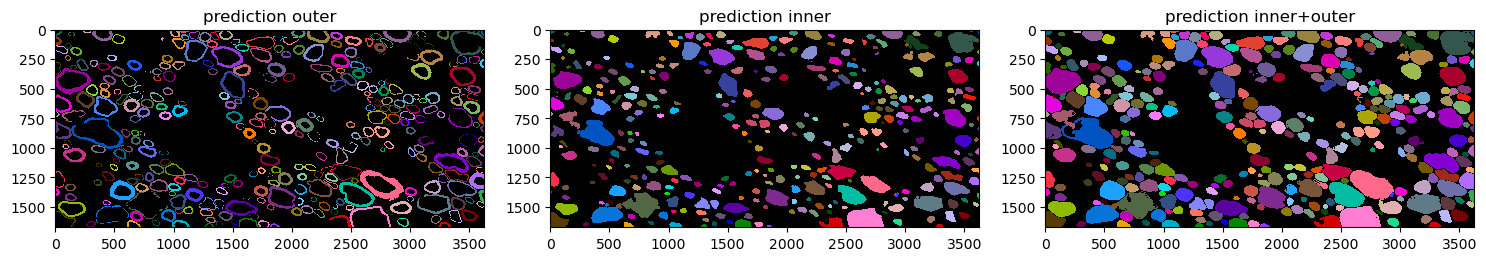

347


In [9]:
pred_outer_labeled,pred_inner_labeled = resolve_undersegmentation(pred_outer_labeled.astype('bool'),pred_inner_labeled.astype('bool'))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('prediction outer')
axs[0].imshow(pred_outer_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axs[1].set_title('prediction inner')
axs[1].imshow(pred_inner_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axs[2].set_title('prediction inner+outer')
axs[2].imshow(pred_inner_labeled + pred_outer_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
plt.tight_layout()
plt.savefig(save_path + "\\pre_predictions_combined.png", dpi=500)
plt.show()

n_pred_cells_corrected = np.max(pred_inner_labeled)
print(n_pred_cells_corrected)

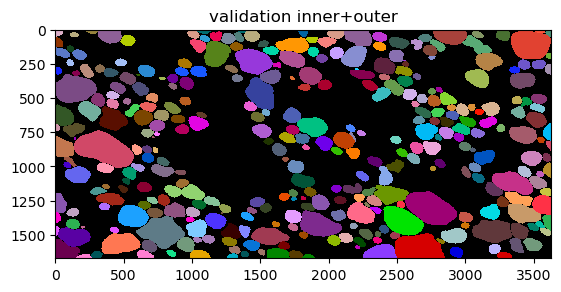

In [10]:
# fill inner to outer label to make sure they touch
# this is needed to ensure good watershed performance later
val_inner = ndi.binary_dilation(val_inner,structure=disk(5))
val_inner[val_outer==True]=0

#re-label so the labels are uniform between both channels.
val_outer_labeled,val_inner_labeled = resolve_undersegmentation(val_outer.astype('bool'),val_inner.astype('bool'))

plt.title('validation inner+outer')
plt.imshow(val_inner_labeled+val_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.show()

In [11]:
# at this point, some of the cells do not have myelin. 
# Since we only look for myelinated cells, these are filtered out here.
idx_list = []
for idx in np.unique(pred_inner_labeled):
    if (pred_outer_labeled==idx).max() == False:
        pred_inner_labeled[pred_inner_labeled==idx] = 0
        idx_list.append(idx)
print('deleted cells because they don\'t have myelin: ' + str(idx_list))

deleted cells because they don't have myelin: [35, 63, 64, 68, 112, 117, 140, 143, 144, 145, 146]


In [12]:
pred_both_labeled = pred_inner_labeled+pred_outer_labeled
val_both_labeled = val_inner_labeled+val_outer_labeled
val_both_labeled[val_both_labeled>0] += 10000 # seperating val and pred labels

#### Cleanup of predicted data without information from validation data
This is the same as in the actual analysis.

In [13]:
#### Post-Process filtering
# if there are multiple independent labels with the same labelling number,
# keep only the biggest one
for id in np.unique(pred_both_labeled):
    if id == 0:
        continue
    current_id_mask = pred_both_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_both_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_both_labeled
        pred_both_labeled[pred_both_labeled==id] = 0
        pred_both_labeled = pred_both_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " inner duplicates from id #" + str(id))

# if fibers are unreasonably small, remove them from further analysis.
for id in np.unique(pred_both_labeled):
    n_px = (np.count_nonzero(pred_both_labeled[pred_both_labeled==id]))
    if n_px < 5:
        pred_both_labeled[pred_both_labeled==id]=0
        print('deleted because smaller than 5 px: cell #' + str(id))

deleted because smaller than 5 px: cell #0


In [14]:
#seperate inner and outer channels from the combined pictures of predictions
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

# if fibers have a g ratio of >1, delete them from the predictions
table = regionprops_table(label_image=pred_inner_labeled,
                          properties=('minor_axis_length',))
measurements_inner = pd.DataFrame(table)

table = regionprops_table(label_image=pred_outer_labeled,
                          properties=('minor_axis_length',))
measurements_outer = pd.DataFrame(table)

#re-label columns
measurements_outer.columns = ['outer_' + col for col in measurements_outer.columns]
measurements_inner.columns = ['inner_' + col for col in measurements_inner.columns]

#put them in a single dataframe
measurements = pd.concat([measurements_inner,measurements_outer],axis=1)

px_size=4.3*4 # px size in nm

# correct all lengths and areas to the right size
factor_length = px_size / 1000 # 10^3 is from nm to µm
measurements['inner_minor_axis_length'] *= factor_length
measurements['outer_minor_axis_length'] *= factor_length

#add gratio to combined dataframe
measurements['gratio'] = measurements['inner_minor_axis_length']/measurements['outer_minor_axis_length']

# remove all cells with gratio >1 (since that is impossible)
index_gratio_greater_than_1 = list(measurements[measurements['gratio'] > 1].index)
index_gratio_greater_than_1 = [index + 1 for index in index_gratio_greater_than_1]
measurements = measurements[measurements['gratio'] <= 1]

# remove them from the combined image before continuing.
for id in np.unique(index_gratio_greater_than_1):
    pred_both_labeled[pred_both_labeled==id]=0

print(f'Cells with g ratio larger than 1: {index_gratio_greater_than_1}')

Cells with g ratio larger than 1: [4, 11, 61, 120, 122, 138, 274, 289, 294, 298, 326]


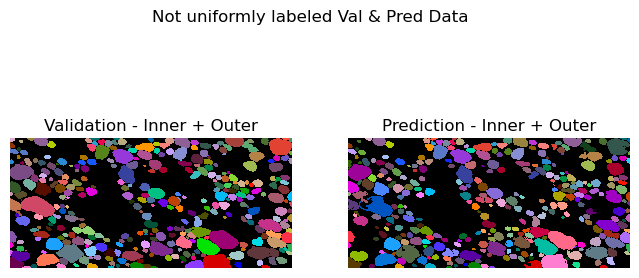

In [15]:
# Plot mislabeled validation and prediction data side by side
plt.figure(figsize=(8, 4))
plt.suptitle('Not uniformly labeled Val & Pred Data', fontsize=12)

# Display mislabeled validation data
plt.subplot(1, 2, 1)
plt.title('Validation - Inner + Outer')
plt.imshow(val_both_labeled, cmap=glasbey, interpolation='none', vmin=10000)
plt.axis('off')

# Display mislabeled prediction data
plt.subplot(1, 2, 2)
plt.title('Prediction - Inner + Outer')
plt.imshow(pred_both_labeled, cmap=glasbey, interpolation='none', vmin=0.1)
plt.axis('off')

# Show the plots side by side
plt.show()


In [16]:
tf.imwrite("4_val/prediction_cc_outer.png",pred_outer_labeled)
tf.imwrite("4_val/prediction_cc_inner.png",pred_inner_labeled)
# tf.imwrite("4_val/val_inner.png",val_inner_labeled)
# tf.imwrite("4_val/val_outer.png",val_outer_labeled)

#### Get pixel-wise validation measures
Here, we take IoU and Dice measures and save a copy of the raw data for plotting them together with the rest of the validation measures at the end of the ipynb.

In [17]:
#seperate inner and outer channels back from the combined pictures
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

val_inner_labeled = np.copy(val_both_labeled)
val_inner_labeled[val_inner==False] = 0

val_outer_labeled = np.copy(val_both_labeled)
val_outer_labeled[val_outer==False] = 0

### calculate IoU scores (before removing false positives/negatives)
iou_inner = calculate_iou(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
iou_outer = calculate_iou(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))
### calculate Dice Coefficients / F1 score
dice_inner = calculate_dice(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
dice_outer = calculate_dice(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))

print(iou_inner,iou_outer,dice_inner,dice_outer)

0.8622051853743298 0.7901724659606657 0.9260044941836141 0.8827892071690792


In [18]:
# take copies of both val and pred data to evaluate in the end, without sorting out false positives and negatives from the data.
pred_copy_before = np.copy(pred_both_labeled)
val_copy_before = np.copy(val_both_labeled)

#### Instance-wise segmentation
Here, we find corresponding cells in prediction and validation data (overlap >40%). For every cell we don't find, we increase the false positive/negative count by 1, respectively.

In [19]:
# find corresponding cells. Threshold for overlap is 40%
n_false_positive = 0
n_false_negative = 0
overlap_thresh = 0.4

overlap_perc_list_1 = []
overlap_perc_list_2 = []

# iterate through validation cells one by one.
for id in np.unique(val_both_labeled):
    if id==0:
        continue
    current_label = val_both_labeled==id
    current_area = np.count_nonzero(current_label.astype('bool'))
    # check if the cell has a sufficiently overlapping prediction cell
    # get bounding box of current cell
    current_measurements = regionprops_table(current_label.astype('uint8'),properties=('area','bbox'))
    # get corresponding slice of predicted cell
    # and find the largest structure in it
    dict_current = np.array((np.unique(pred_both_labeled[current_measurements['bbox-0'][0]
                                                   :current_measurements['bbox-2'][0]
                                                   ,current_measurements['bbox-1'][0]
                                                   :current_measurements['bbox-3'][0]
                                                   ],return_counts=True)))
    try:
        current_maximum = dict_current[1,1:].max() # find largest structure
    except ValueError:
        print(f'overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# {id}')
        continue
    y,x = np.argwhere(dict_current==current_maximum)[0] #get its y and x coordinates in the table of labeled structures
    current_pred_id = dict_current[y-1,x] # get the corresponding pred label number
    
    # check the overlap between the structure in pred and val
    overlap_abs = np.logical_and(pred_both_labeled==current_pred_id,val_both_labeled==id)
    overlap_perc = np.count_nonzero(overlap_abs)/np.count_nonzero(current_label)
    overlap_perc_list_1.append(overlap_perc)

    if overlap_perc > overlap_thresh:# if the overlap threshold is met:
        # print('overlap thresh met. labelling with the same color as in val.')
        pred_both_labeled[pred_both_labeled==current_pred_id] = id
    else: # if the overlap is not met: 
        val_both_labeled[val_both_labeled==id] = 0
        n_false_negative += 1
        # print(f'overlap thresh not met. increase false negative by 1 and deleting cell# {id}')
        if current_pred_id == None:
            print('None')
            break
    

overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10001
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10010
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10051
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10060
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10076
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10166
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10170
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10243
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10269
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10291


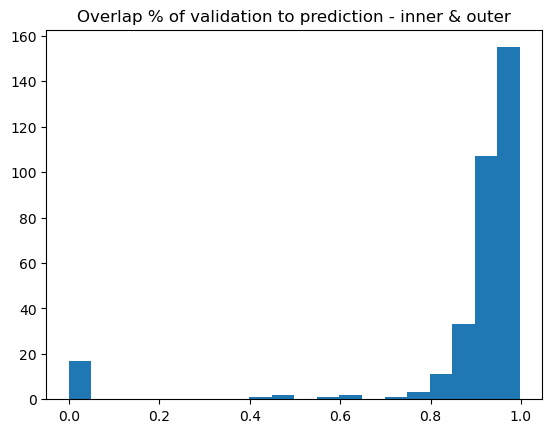

In [20]:
plt.title("Overlap % of validation to prediction - inner & outer")
plt.hist(overlap_perc_list_1,bins=20) #sanity check
plt.show()

In [21]:
# iterate through prediction cells one by one.
for id in np.unique(pred_both_labeled):
    if id==0:
        continue
    current_label = pred_both_labeled==id
    current_area = np.count_nonzero(current_label.astype('bool'))
    # plt.imshow(current_label)
    # check if the cell has a sufficiently overlapping prediction cell
    # get bounding box of current cell
    current_measurements = regionprops_table(current_label.astype('uint8'),properties=('area','bbox'))
    # get corresponding slice of predicted cell
    # and find the largest structure in it
    dict_current = np.array((np.unique(val_both_labeled[current_measurements['bbox-0'][0]
                                                   :current_measurements['bbox-2'][0]
                                                   ,current_measurements['bbox-1'][0]
                                                   :current_measurements['bbox-3'][0]
                                                   ],return_counts=True)))
    try:
        current_maximum = dict_current[1,1:].max() # find largest structure
    except ValueError:
        print(f'overlap thresh not met (cell not found). increase false positive by and and deleting cell# {id}')
        continue
    y,x = np.argwhere(dict_current==current_maximum)[0] #get its y and x coordinates in the table of labeled structures
    current_val_id = dict_current[y-1,x] # get the corresponding val label number
    
    # check the overlap between the structure in pred and val
    overlap_abs = np.logical_and(val_both_labeled==current_val_id,pred_both_labeled==id)
    overlap_perc = np.count_nonzero(overlap_abs)/np.count_nonzero(current_label)
    overlap_perc_list_2.append(overlap_perc)
    if overlap_perc > overlap_thresh:# if the overlap threshold is met:
        # print('overlap thresh met. labelling with the same color as in val.')
        pred_both_labeled[pred_both_labeled==id] = current_val_id
    
    else: # if the overlap is not met: 
        pred_both_labeled[pred_both_labeled==id] = 0
        n_false_positive += 1
        # print(f'overlap thresh not met. increase false positive by 1 and deleting cell# {id}')
        if current_val_id == None:
            print('None')
            break

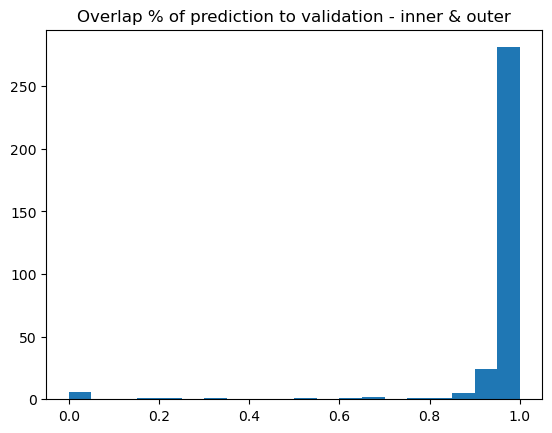

In [22]:
plt.title("Overlap % of prediction to validation - inner & outer")
plt.hist(overlap_perc_list_2,bins=20) #sanity check
plt.show()

In [23]:
print(f"Number of cells in prediction dataset: {len(np.unique(pred_both_labeled))}")
print(f"Number of cells in validation dataset: {len(np.unique(val_both_labeled))}")

Number of cells in prediction dataset: 313
Number of cells in validation dataset: 327


In [24]:
# here, we hard filter every cell that does not have a correspondingly labeled val or pred cell.
# iterate through np.unique(pred_both_labeled), delete all cells that do not have corresponding val cell.
# then do the same other way around.
for id in np.unique(pred_both_labeled):
    # check if id is in val_outer_labeled
    if id not in val_both_labeled:
        # if not, delete in pred_outer_labeled
        pred_both_labeled[pred_both_labeled==id] = 0
        print("deleted prediction label #" + str(id))
        n_false_positive += 1
        print(n_false_positive)

for id in np.unique(val_both_labeled):
    if id not in pred_both_labeled:
        # if not, delete in pred_both_labeled
        val_both_labeled[val_both_labeled==id] = 0
        print("deleted validation label #" + str(id))
        n_false_negative += 1
        print(n_false_negative)


# revert labels back to low values
pred_both_labeled -= 10000
val_both_labeled -= 10000
pred_both_labeled[pred_both_labeled<0]=0
val_both_labeled[val_both_labeled<0]=0

deleted validation label #10001
18
deleted validation label #10010
19
deleted validation label #10051
20
deleted validation label #10060
21
deleted validation label #10065
22
deleted validation label #10076
23
deleted validation label #10114
24
deleted validation label #10166
25
deleted validation label #10170
26
deleted validation label #10243
27
deleted validation label #10255
28
deleted validation label #10266
29
deleted validation label #10269
30
deleted validation label #10291
31


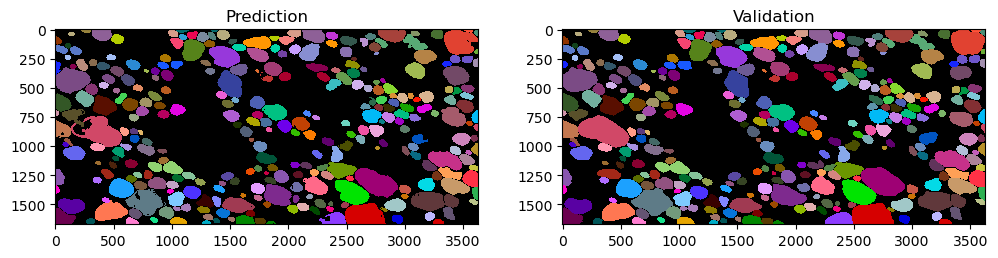

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(pred_both_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axes[0].set_title('Prediction')
axes[1].imshow(val_both_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axes[1].set_title('Validation')
plt.show()


In [26]:
print(f"Number of cells in prediction dataset: {len(np.unique(pred_both_labeled))}")
print(f"Number of cells in validation dataset: {len(np.unique(val_both_labeled))}")

Number of cells in prediction dataset: 313
Number of cells in validation dataset: 313


In [27]:
#seperate inner and outer channels back from the combined pictures
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

val_inner_labeled = np.copy(val_both_labeled)
val_inner_labeled[val_inner==False] = 0

val_outer_labeled = np.copy(val_both_labeled)
val_outer_labeled[val_outer==False] = 0

In [28]:
# print(len(np.unique(pred_outer_labeled)))
# print(len(np.unique(pred_inner_labeled)))
# print(len(np.unique(val_outer_labeled)))
# print(len(np.unique(val_inner_labeled)))

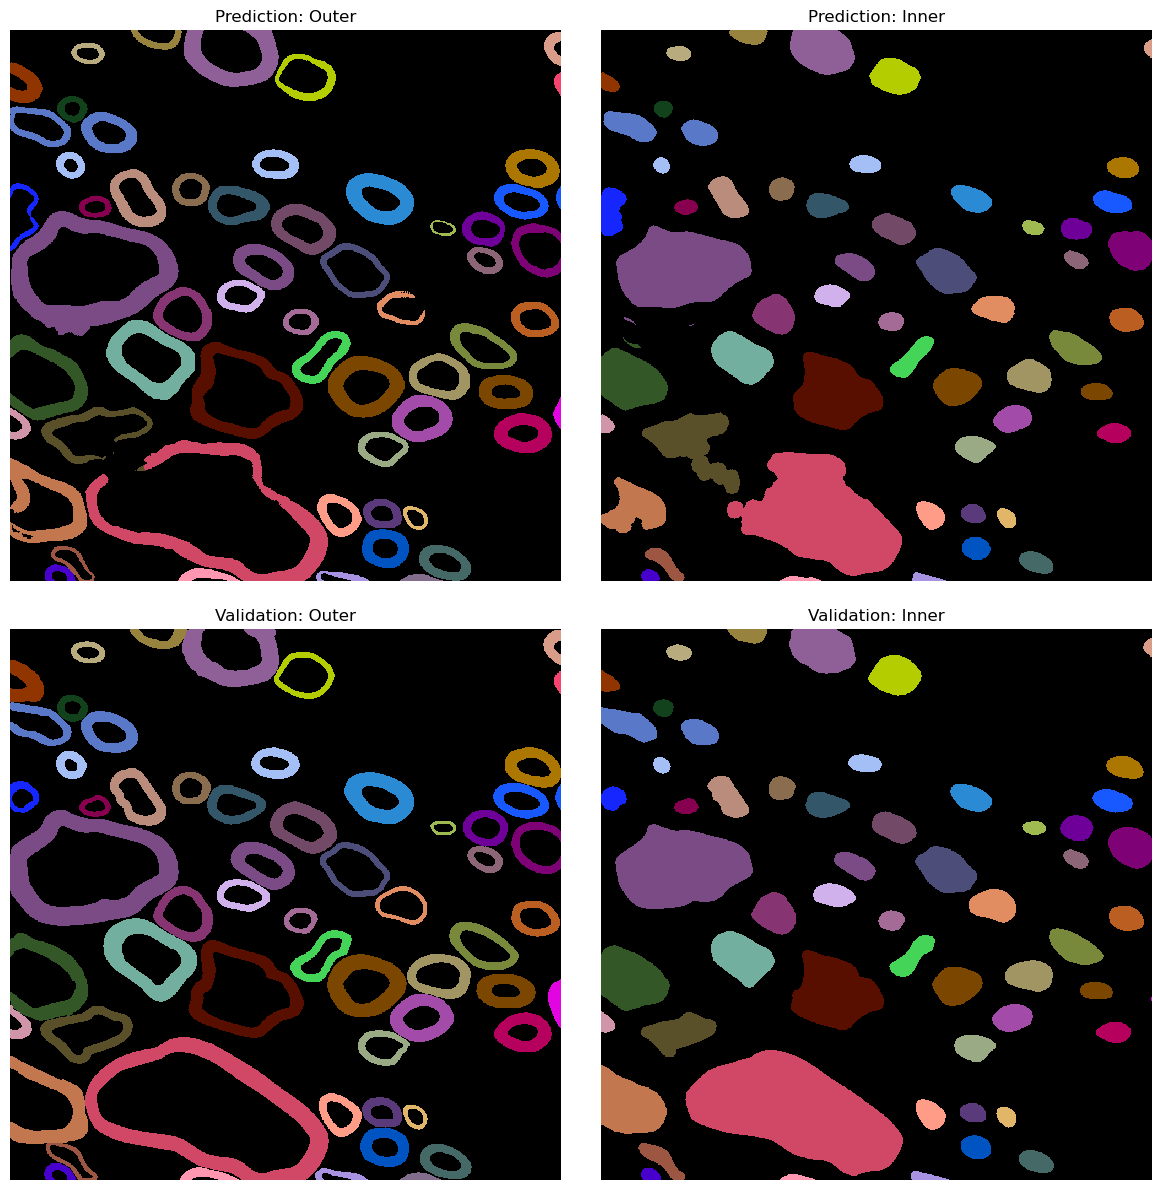

In [29]:
#plot all four channels in 2x2 grid
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
axs[0,0].imshow(pred_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0,1].imshow(pred_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,0].imshow(val_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,1].imshow(val_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
# Remove axis for each subplot
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[0,0].set_title('Prediction: Outer')
axs[0,1].set_title('Prediction: Inner')
axs[1,0].set_title('Validation: Outer')
axs[1,1].set_title('Validation: Inner')
plt.tight_layout(h_pad=2)
plt.savefig(save_path + "\predict_val_comparison.png",dpi=500)
plt.show()

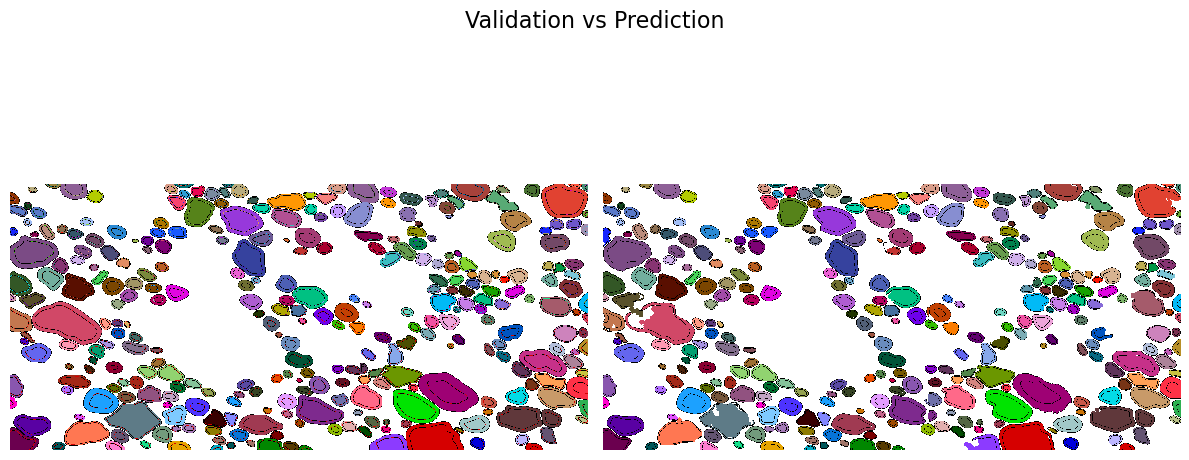

In [30]:
# Function to create outline
def create_outline(image):
    eroded = ndi.binary_erosion(image, structure=disk(3))
    return np.logical_xor(image.astype('bool'), eroded)

# Plot overlay of inner + outer for validation
val_outer_eroded = create_outline(val_outer_labeled)
val_overlay = np.ma.array(val_inner_labeled + val_outer_labeled, mask=(val_inner_labeled + val_outer_labeled) == 0)
val_outline = np.ma.array(val_outer_eroded, mask=(val_outer_eroded) == 0)

plt.figure(figsize=(12, 6))
# Display overlay
plt.subplot(1, 2, 1)
plt.imshow(val_overlay, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.imshow(val_outline, interpolation='none', cmap='gray')
plt.axis('off')

# Plot overlay of inner + outer for prediction
pred_outer_eroded = create_outline(pred_outer_labeled)
pred_overlay = np.ma.array(pred_inner_labeled + pred_outer_labeled, mask=(pred_inner_labeled + pred_outer_labeled) == 0)
pred_outline = np.ma.array(pred_outer_eroded, mask=(pred_outer_eroded) == 0)

plt.subplot(1, 2, 2)
plt.imshow(pred_overlay, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.imshow(pred_outline, interpolation='none', cmap='gray')
plt.axis('off')
plt.suptitle('Validation vs Prediction', fontsize=16)

# Save figures
plt.savefig(save_path + "overlay_and_outlined_cells.png", dpi=500)
plt.tight_layout()
plt.show()


In [31]:
# plt.axis("off")
# plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# # plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
# plt.show()

# plt.axis("off")
# plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# # plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
# plt.show()

In [32]:
# iterate through np.unique(pred_inner_labeled), delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        val_inner_labeled[val_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        val_outer_labeled[val_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

In [33]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Inner
for id in np.unique(pred_inner_labeled):
    if id == 0:
        continue
    current_id_mask = pred_inner_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        pred_inner_labeled = pred_inner_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 3 duplicates from id #36
Removed 1 duplicates from id #47
Removed 1 duplicates from id #75
Removed 3 duplicates from id #95
Removed 2 duplicates from id #127
Removed 1 duplicates from id #135
Removed 1 duplicates from id #140
Removed 2 duplicates from id #178
Removed 1 duplicates from id #263
Removed 1 duplicates from id #286
Removed 2 duplicates from id #296
Removed 5 duplicates from id #306
Removed 3 duplicates from id #318


In [34]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Outer
for id in np.unique(pred_outer_labeled):
    if id == 0:
        continue
    current_id_mask = pred_outer_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        pred_outer_labeled = pred_outer_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 1 duplicates from id #5
Removed 5 duplicates from id #28
Removed 1 duplicates from id #29
Removed 1 duplicates from id #144
Removed 1 duplicates from id #149
Removed 7 duplicates from id #155
Removed 3 duplicates from id #165
Removed 1 duplicates from id #178
Removed 1 duplicates from id #286
Removed 2 duplicates from id #300
Removed 8 duplicates from id #301
Removed 1 duplicates from id #318


In [35]:
# making sure we now have the same number of instances in all images
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(len(np.unique(val_outer_labeled)))
print(len(np.unique(val_inner_labeled)))

313
313
313
313


In [36]:
tf.imwrite(save_path + "/pred_inner_labeled.tif",pred_inner_labeled)
tf.imwrite(save_path + "/pred_outer_labeled.tif",pred_outer_labeled)
tf.imwrite(save_path + "/val_inner_labeled.tif",val_inner_labeled)
tf.imwrite(save_path + "/val_outer_labeled.tif",val_outer_labeled)
# tf.imwrite(save_path + "/bool_array_labeled.tif",bool_array_labeled_dil)

In [37]:
### calculate IoU scores (after)
iou_inner_after = calculate_iou(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
iou_outer_after = calculate_iou(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))
### calculate Dice Coefficients / F1 score
dice_inner_after = calculate_dice(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
dice_outer_after = calculate_dice(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))

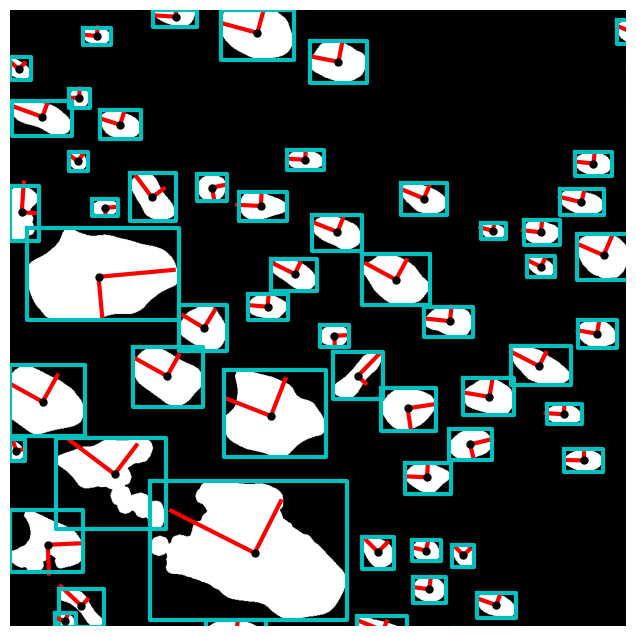

In [38]:
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_inner_labeled)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(pred_inner_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=3)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=3)
    ax.plot(x0, y0, '.k', markersize=10)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=3)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\inner_clocks.png",dpi=500)
plt.show()

In [39]:
### For any validation measures that are not cell-wise but population-wise: 
pred_inner_labeled_before = np.copy(pred_copy_before)
pred_inner_labeled_before[pred_inner==False]=0

pred_outer_labeled_before = np.copy(pred_copy_before)
pred_outer_labeled_before[pred_outer==False]=0

val_inner_labeled_before = np.copy(val_copy_before)
val_inner_labeled_before[val_inner==False] = 0

val_outer_labeled_before = np.copy(val_copy_before)
val_outer_labeled_before[val_outer==False] = 0

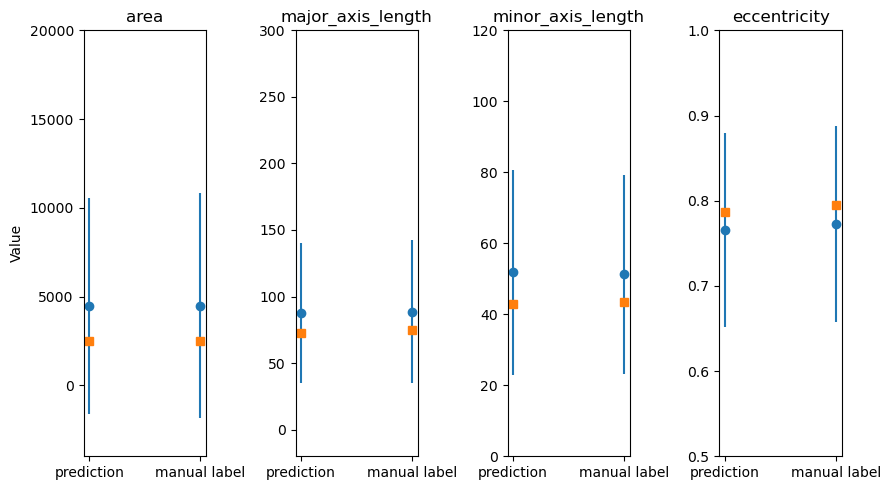

In [40]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_inner_pred = regionprops_table(label_image=pred_inner_labeled_before,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice',))
measurements_inner_pred = pd.DataFrame(table_inner_pred)

table_inner_val = regionprops_table(label_image=val_inner_labeled_before,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'major_axis_length',
                                          'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice',))
measurements_inner_val = pd.DataFrame(table_inner_val)

# drop uninteresting columns for now
measurements_inner_val=measurements_inner_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_inner_pred=measurements_inner_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_inner_pred = pd.concat([measurements_inner_pred.mean(),measurements_inner_pred.median(), measurements_inner_pred.std()], axis=1)
stats_inner_pred.columns = ['mean','median', 'std']
stats_inner_pred['dataset'] = 'prediction'

stats_inner_val = pd.concat([measurements_inner_val.mean(),measurements_inner_val.median(), measurements_inner_val.std()], axis=1)
stats_inner_val.columns = ['mean','median', 'std']
stats_inner_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_inner_pred, stats_inner_val])

# plot the data as a box plot
fig, axs = plt.subplots(ncols=measurements_inner_pred.shape[1], figsize=(9, 5),)

for i, col in enumerate(measurements_inner_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,20000)
    if i == 1:
        ax.set_ylim(-20,300)
    if i == 2:
        ax.set_ylim(0,120)
    if i == 3:
        ax.set_ylim(0.5,1)
    
plt.tight_layout()
plt.savefig(save_path + "\inner_lineplot.png",dpi=500)
plt.show()

In [41]:
print('predicted stats:')
print(stats_inner_pred)
print('')
print('validation stats:')
print(stats_inner_val)

predicted stats:
                          mean       median          std     dataset
area               4457.150769  2490.000000  6096.335549  prediction
major_axis_length    87.423596    72.813831    52.464960  prediction
minor_axis_length    51.802569    42.792130    28.952971  prediction
eccentricity          0.765715     0.786325     0.114307  prediction

validation stats:
                          mean       median          std       dataset
area               4494.206997  2482.000000  6330.245452  manual label
major_axis_length    88.663074    74.524848    53.746103  manual label
minor_axis_length    51.260769    43.361610    28.084222  manual label
eccentricity          0.772806     0.795421     0.115086  manual label


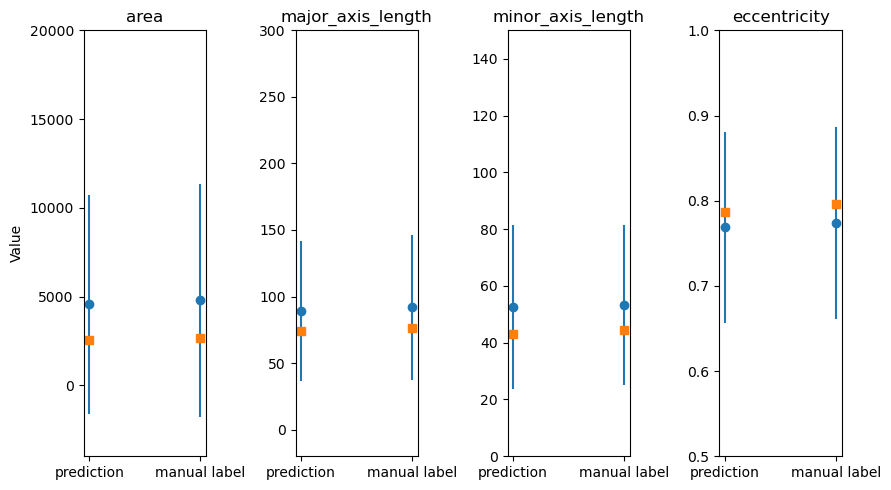

In [42]:
### now do the same, but for the corrected data which has paired cells

## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_inner_pred = regionprops_table(label_image=pred_inner_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice',))
measurements_inner_pred = pd.DataFrame(table_inner_pred)

table_inner_val = regionprops_table(label_image=val_inner_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'major_axis_length',
                                          'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice',))
measurements_inner_val = pd.DataFrame(table_inner_val)

# drop uninteresting columns for now
measurements_inner_val=measurements_inner_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_inner_pred=measurements_inner_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_inner_pred = pd.concat([measurements_inner_pred.mean(),measurements_inner_pred.median(), measurements_inner_pred.std()], axis=1)
stats_inner_pred.columns = ['mean','median', 'std']
stats_inner_pred['dataset'] = 'prediction'

stats_inner_val = pd.concat([measurements_inner_val.mean(),measurements_inner_val.median(), measurements_inner_val.std()], axis=1)
stats_inner_val.columns = ['mean','median', 'std']
stats_inner_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_inner_pred, stats_inner_val])

# plot the data as a box plot
fig, axs = plt.subplots(ncols=measurements_inner_pred.shape[1], figsize=(9, 5),)

for i, col in enumerate(measurements_inner_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,20000)
    if i == 1:
        ax.set_ylim(-20,300)
    if i == 2:
        ax.set_ylim(0,150)
    if i == 3:
        ax.set_ylim(0.5,1)
    
plt.tight_layout()
# plt.savefig(save_path + "\inner_lineplot_after.png",dpi=500)
plt.show()

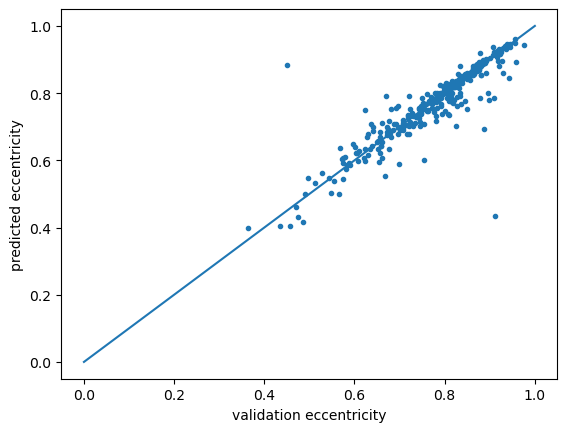

LinregressResult(slope=0.8939431274295908, intercept=0.07738063598000788, rvalue=0.8979224215526714, pvalue=1.658451225014448e-112, stderr=0.0248882656938897, intercept_stderr=0.019454346292136496)


In [43]:
set_val = (measurements_inner_val['eccentricity'])
set_pred = (measurements_inner_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\inner_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

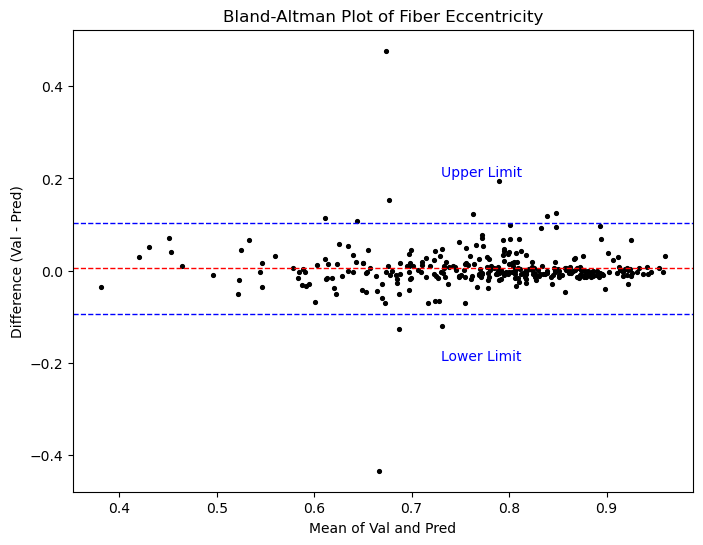

In [44]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


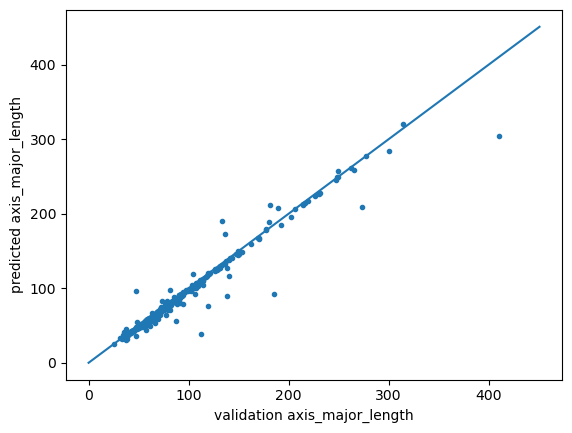

LinregressResult(slope=0.9421323569198844, intercept=2.350677778500568, rvalue=0.975039937406548, pvalue=1.1328045730296482e-204, stderr=0.012184829149193856, intercept_stderr=1.3020657565866265)


In [45]:
set_val = (measurements_inner_val['major_axis_length'])
set_pred = (measurements_inner_pred['major_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
#plt.ylim(-20,520)
#plt.xlim(-20,520)
plt.savefig(save_path + "\inner_major.png",dpi=500)
plt.show()
print(stats_val_pred)

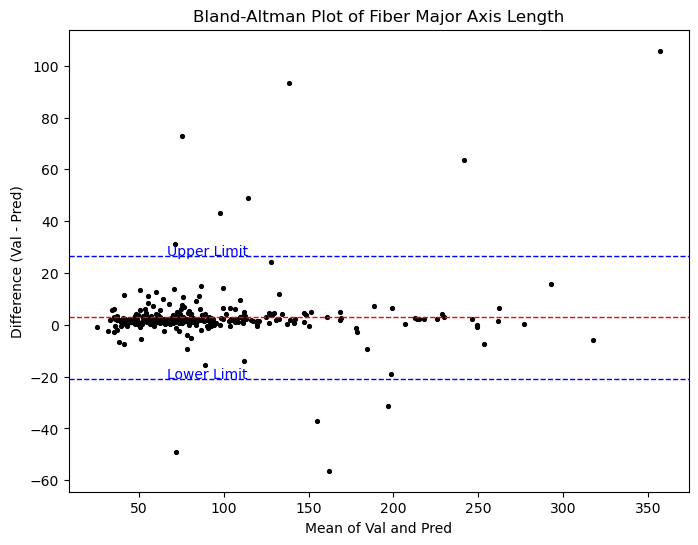

In [46]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30,marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Display the plot
plt.show()


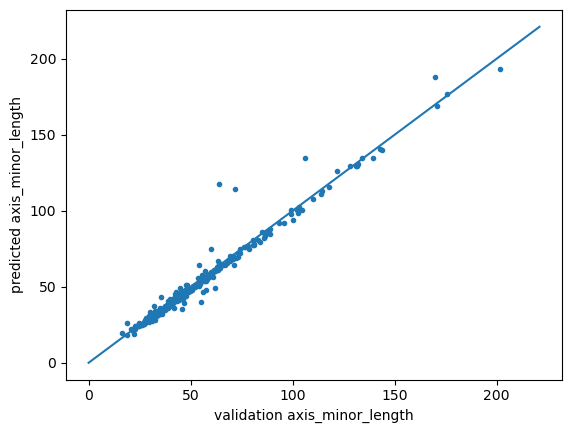

LinregressResult(slope=1.00548276880753, intercept=-1.1385245557732588, rvalue=0.9840790139576041, pvalue=1.229750499927138e-234, stderr=0.010314027326228995, intercept_stderr=0.6219458742493489)


In [47]:
set_val = (measurements_inner_val['minor_axis_length'])
set_pred = (measurements_inner_pred['minor_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\inner_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

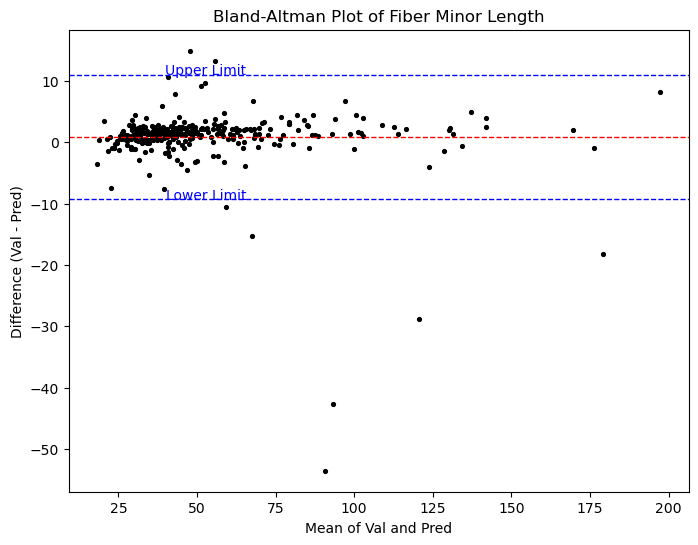

In [48]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Minor Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_minor_ba.png",dpi=500)

# Display the plot
plt.show()


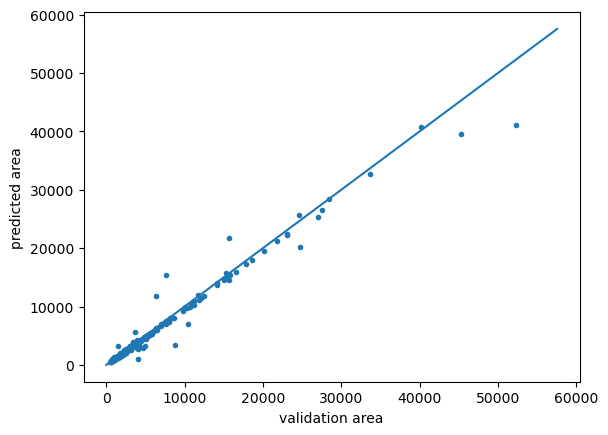

LinregressResult(slope=0.9292627306377502, intercept=121.51221898685253, rvalue=0.9864371564449974, pvalue=2.3865266901866118e-245, stderr=0.008782153853743854, intercept_stderr=71.16212622715304)


In [49]:
set_val = (measurements_inner_val['area'])
set_pred = (measurements_inner_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)
x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\inner_area.png",dpi=500)
plt.show()
print(stats_val_pred)

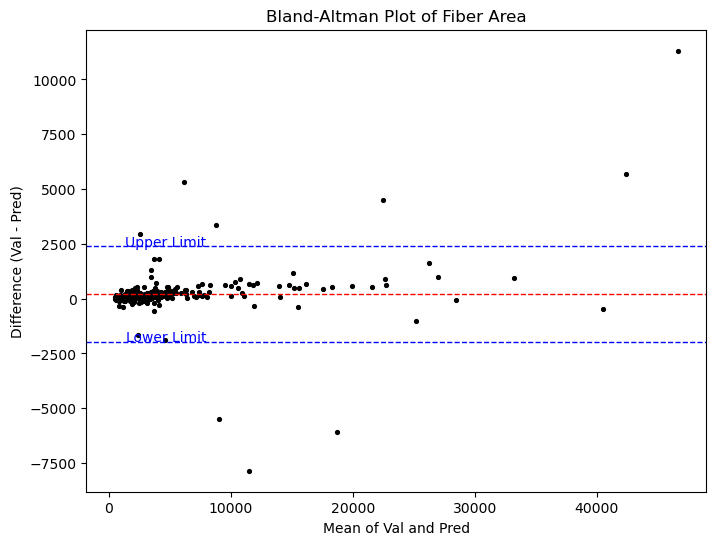

In [50]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_area_ba.png",dpi=500)

# Display the plot
plt.show()


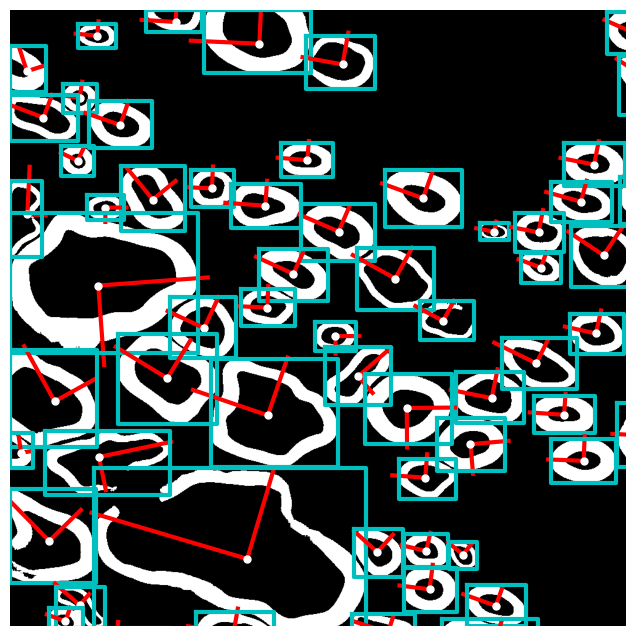

In [51]:
##### now do the same as above for the outer channel
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_outer_labeled)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(pred_outer_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=3)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=3)
    ax.plot(x0, y0, '.w', markersize=10)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=3)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\outer_clocks.png",dpi=500)
plt.show()

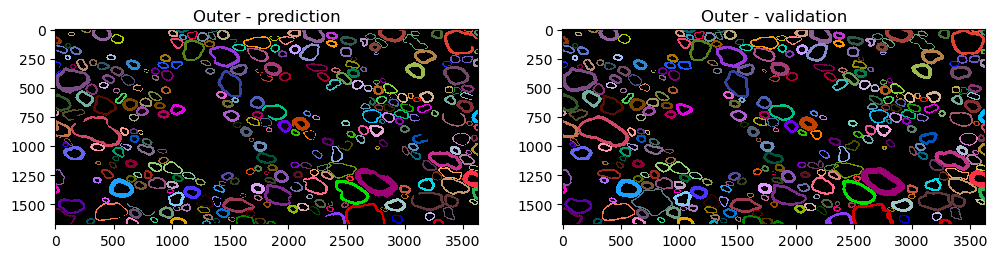

In [52]:
## do the same regression analysis as before
# visually compare outer_labeled and validation data
fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1].imshow(val_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0].set_title('Outer - prediction')
axs[1].set_title('Outer - validation')
plt.show()

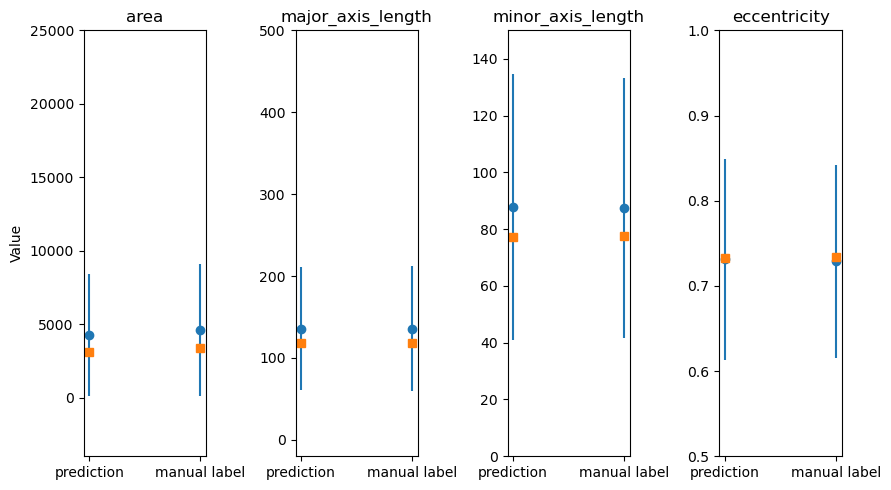

In [53]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_outer_pred = regionprops_table(label_image=pred_outer_labeled_before,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice'))
measurements_outer_pred = pd.DataFrame(table_outer_pred)
#measurements_outer_pred.drop(66,inplace=True)

table_outer_val = regionprops_table(label_image=val_outer_labeled_before,
                              properties=('label',
                                          'area',
                                          'centroid',
                                        'major_axis_length',
                                        'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice'))
measurements_outer_val = pd.DataFrame(table_outer_val)
#measurements_outer_val.drop(66,inplace=True)

# drop uninteresting columns for now
measurements_outer_val=measurements_outer_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_outer_pred=measurements_outer_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_outer_pred = pd.concat([measurements_outer_pred.mean(),measurements_outer_pred.median(), measurements_outer_pred.std()], axis=1)
stats_outer_pred.columns = ['mean','median', 'std']
stats_outer_pred['dataset'] = 'prediction'

stats_outer_val = pd.concat([measurements_outer_val.mean(),measurements_outer_val.median(), measurements_outer_val.std()], axis=1)
stats_outer_val.columns = ['mean','median', 'std']
stats_outer_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_outer_pred, stats_outer_val])

fig, axs = plt.subplots(ncols=measurements_outer_pred.shape[1], figsize=(9, 5))

for i, col in enumerate(measurements_outer_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,25000)
    if i == 1:
        ax.set_ylim(-20,500)
    if i == 2:
        ax.set_ylim(0,150)
    if i == 3:
        ax.set_ylim(0.5,1)

plt.tight_layout()
plt.savefig(save_path + "\outer_lineplot.png", dpi=500)
plt.show()

In [54]:
print('predicted stats:')
print(stats_outer_pred)
print('')
print('validation stats:')
print(stats_outer_val)

predicted stats:
                          mean       median          std     dataset
area               4252.658462  3116.000000  4123.773269  prediction
major_axis_length   135.872244   118.425846    74.627576  prediction
minor_axis_length    87.879070    77.244956    46.812329  prediction
eccentricity          0.731390     0.732811     0.118074  prediction

validation stats:
                          mean       median          std       dataset
area               4595.177843  3359.000000  4523.753366  manual label
major_axis_length   135.911597   118.820336    76.147022  manual label
minor_axis_length    87.402435    77.635152    45.705011  manual label
eccentricity          0.728807     0.733800     0.113282  manual label


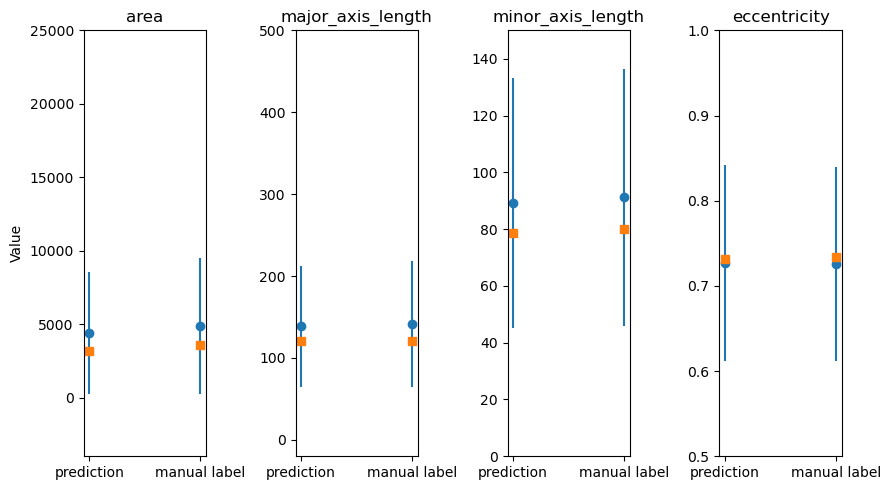

In [55]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_outer_pred = regionprops_table(label_image=pred_outer_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice'))
measurements_outer_pred = pd.DataFrame(table_outer_pred)
#measurements_outer_pred.drop(66,inplace=True)

table_outer_val = regionprops_table(label_image=val_outer_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                        'major_axis_length',
                                        'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice'))
measurements_outer_val = pd.DataFrame(table_outer_val)
#measurements_outer_val.drop(66,inplace=True)

# drop uninteresting columns for now
measurements_outer_val=measurements_outer_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_outer_pred=measurements_outer_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_outer_pred = pd.concat([measurements_outer_pred.mean(),measurements_outer_pred.median(), measurements_outer_pred.std()], axis=1)
stats_outer_pred.columns = ['mean','median', 'std']
stats_outer_pred['dataset'] = 'prediction'

stats_outer_val = pd.concat([measurements_outer_val.mean(),measurements_outer_val.median(), measurements_outer_val.std()], axis=1)
stats_outer_val.columns = ['mean','median', 'std']
stats_outer_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_outer_pred, stats_outer_val])

fig, axs = plt.subplots(ncols=measurements_outer_pred.shape[1], figsize=(9, 5))

for i, col in enumerate(measurements_outer_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,25000)
    if i == 1:
        ax.set_ylim(-20,500)
    if i == 2:
        ax.set_ylim(0,150)
    if i == 3:
        ax.set_ylim(0.5,1)
plt.tight_layout()
# plt.savefig(save_path + "\outer_lineplot.png", dpi=500)
plt.show()

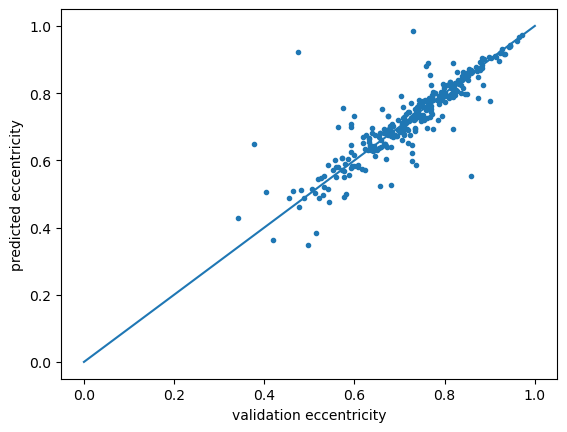

LinregressResult(slope=0.8933027854212284, intercept=0.07844459590087838, rvalue=0.8826132958413729, pvalue=1.2264483981925106e-103, stderr=0.02702323831055915, intercept_stderr=0.01984845912200968)


In [56]:
set_val = (measurements_outer_val['eccentricity'])
set_pred = (measurements_outer_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)
x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\outer_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

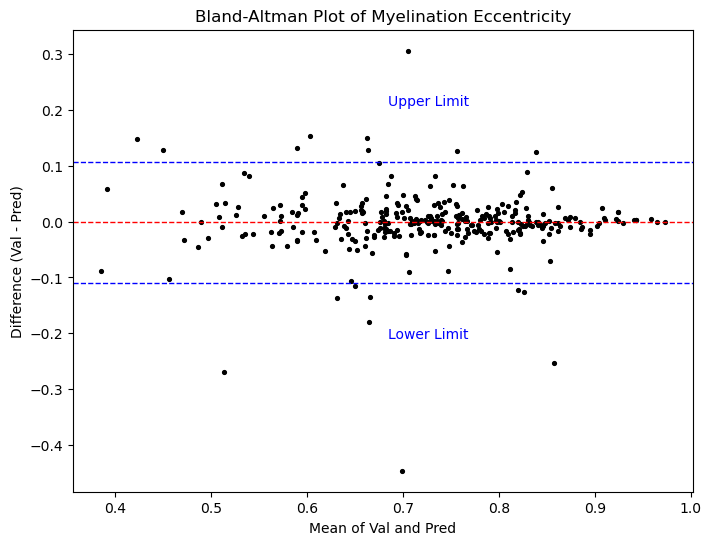

In [57]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


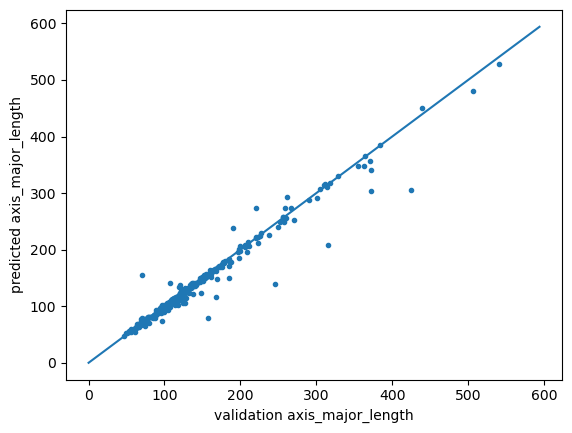

LinregressResult(slope=0.9403480373736556, intercept=5.528906512787671, rvalue=0.9795714697425629, pvalue=5.249307000658583e-218, stderr=0.0109641710414951, intercept_stderr=1.7620946798495793)


In [58]:
set_val = (measurements_outer_val['major_axis_length'])
set_pred = (measurements_outer_pred['major_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
plt.savefig(save_path + "\outer_major.png",dpi=500)
plt.show()
print(stats_val_pred)

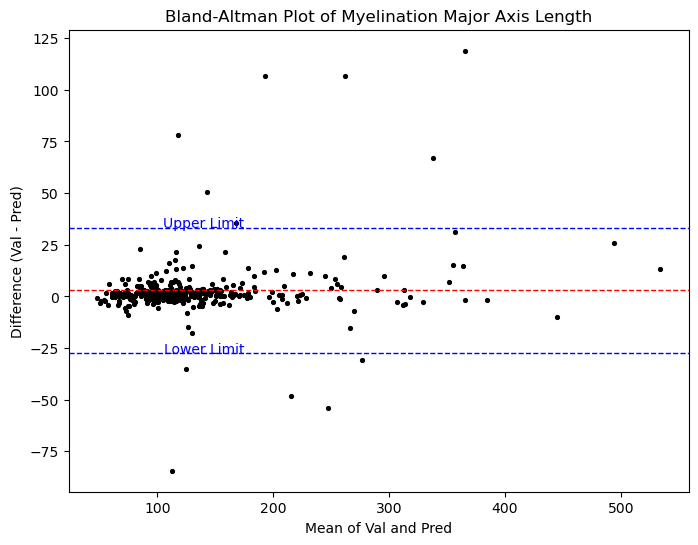

In [59]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_major_ba.png",dpi=500)

# Display the plot
plt.show()


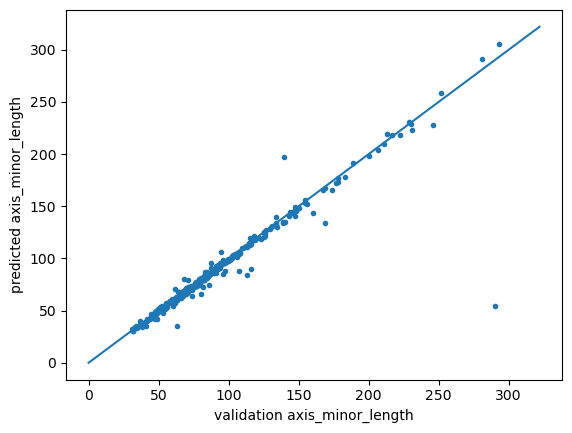

LinregressResult(slope=0.9223583269855916, intercept=5.031848445259314, rvalue=0.9476998709734665, pvalue=8.373822852739681e-156, stderr=0.01764251122289541, intercept_stderr=1.7963846145959281)


In [60]:
set_val = (measurements_outer_val['minor_axis_length'])
set_pred = (measurements_outer_pred['minor_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\outer_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

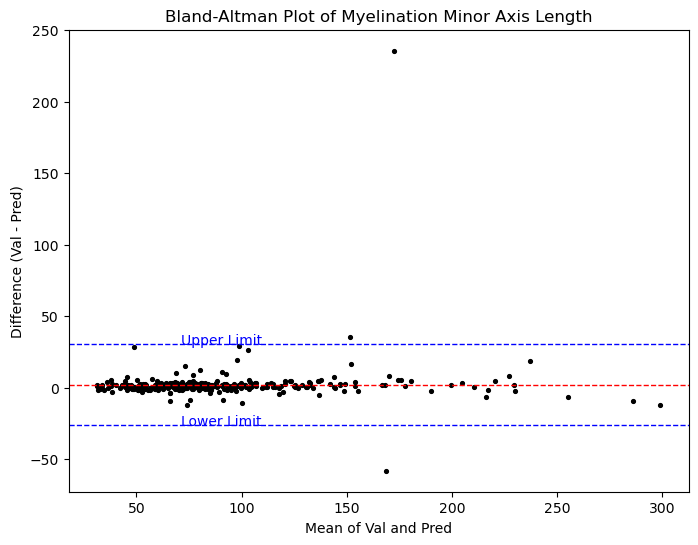

In [61]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Minor Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_minor_ba.png",dpi=500)

# Display the plot
plt.show()


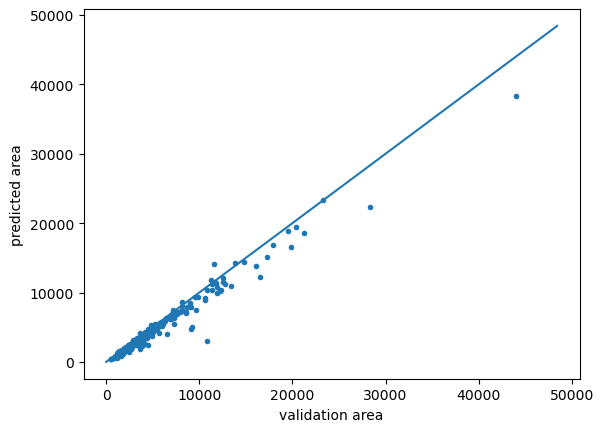

LinregressResult(slope=0.885793413138753, intercept=58.72885222550212, rvalue=0.9844627132037913, pvalue=2.887186783297128e-236, stderr=0.008973490152484796, intercept_stderr=60.091592667726516)


In [62]:
set_val = (measurements_outer_val['area'])
set_pred = (measurements_outer_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\outer_area.png",dpi=500)
plt.show()
print(stats_val_pred)

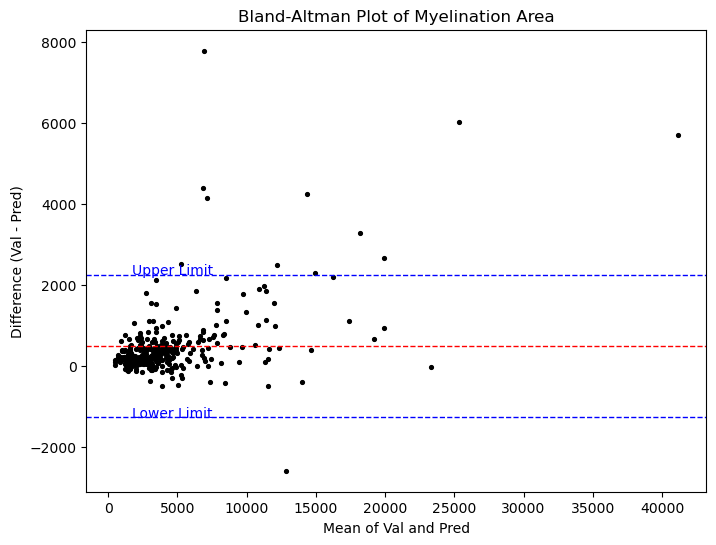

In [63]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_area_ba.png",dpi=500)

# Display the plot
plt.show()


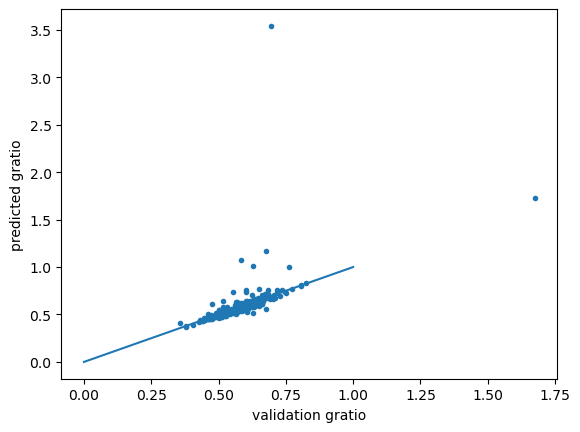

LinregressResult(slope=1.1440761124317016, intercept=-0.07600326690561554, rvalue=0.5396264184678679, pvalue=5.649132718341168e-25, stderr=0.1013780053079299, intercept_stderr=0.06016104098379459)


In [64]:
gratio_pred = measurements_inner_pred['minor_axis_length']/measurements_outer_pred['minor_axis_length']
gratio_val  = measurements_inner_val['minor_axis_length']/measurements_outer_val['minor_axis_length']

stats_val_pred = scipy.stats.linregress(gratio_val,gratio_pred)

plt.scatter(gratio_val,gratio_pred,marker='.')
plt.plot([0, 1], [0, 1])
plt.xlabel('validation gratio')
plt.ylabel('predicted gratio')
plt.savefig(save_path + "\gratio.png",dpi=500)
plt.show()
print(stats_val_pred)

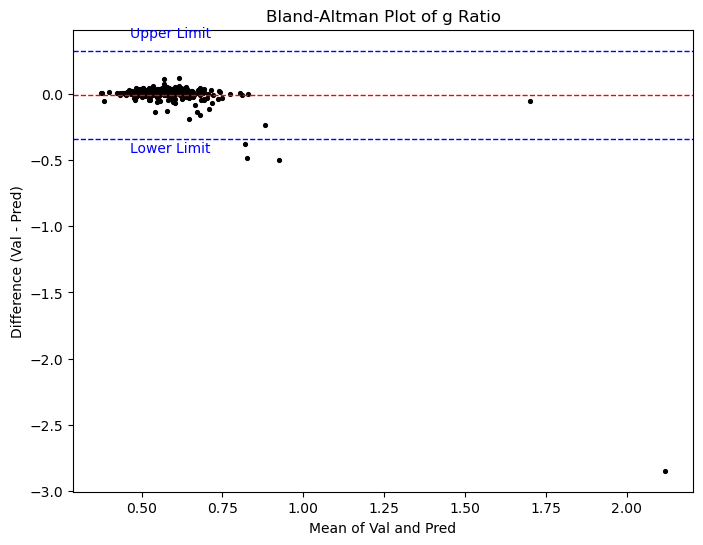

In [65]:
set_val = np.array(gratio_val)
set_pred = np.array(gratio_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of g Ratio')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\gratio_ba.png",dpi=500)

# Display the plot
plt.show()

In [66]:
# print all statistics
print ("Correctly identified cells: " + str (len(set_pred)))
print ("False Positives: " + str (n_false_positive))
print ("False Negatives: " + str (n_false_negative))
print ("Percentage of cells found: " + str(len(set_pred)/(len(set_pred)+n_false_negative))) # found cells divided by found cells + false negatives
print ("Percentage of cells falsely identified: " + str(n_false_positive/(len(set_pred)+n_false_positive)))
print ("Cells removed because labeled without inner (prediction): " + str (n_labeled_without_inner))
print ("Cells removed because labeled without outer (prediction): " + str (n_labeled_without_outer))
print ("IoU/Jaccard for fibers: " + str (iou_inner))
print ("IoU/Jaccard for myelin: "+ str (iou_outer))
print ("dice coefficient / F1: " + str (dice_inner))
print ("dice coefficient / F1: " + str (dice_outer))

Correctly identified cells: 312
False Positives: 9
False Negatives: 31
Percentage of cells found: 0.9096209912536443
Percentage of cells falsely identified: 0.028037383177570093
Cells removed because labeled without inner (prediction): 0
Cells removed because labeled without outer (prediction): 10
IoU/Jaccard for fibers: 0.8622051853743298
IoU/Jaccard for myelin: 0.7901724659606657
dice coefficient / F1: 0.9260044941836141
dice coefficient / F1: 0.8827892071690792


In [67]:
# Correctly identified cells: 124
# False Positives: 20
# False Negatives: 29
# Percentage of cells found: 0.8104575163398693
# Percentage of cells falsely identified: 0.1388888888888889
# Cells removed because labeled without inner (prediction): 0
# Cells removed because labeled without outer (prediction): 21
# IoU/Jaccard for fibers: 0.7441988372924424
# IoU/Jaccard for myelin: 0.5549547630385203
# dice coefficient / F1: 0.8533417422152149
# dice coefficient / F1: 0.7137889490162264